In [6]:
import torch
import torch.nn as nn
from torchinfo import summary

import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import *
import numpy as np
import sys

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.BatchNorm2d(num_features=6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=16 * 4 * 4, out_features=120),
            nn.BatchNorm1d(num_features=120),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.BatchNorm1d(num_features=84),
            nn.ReLU(),
        )
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [8]:
summary(LeNet(), input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 6, 12, 12]            --
│    └─Conv2d: 2-1                       [1, 6, 24, 24]            156
│    └─BatchNorm2d: 2-2                  [1, 6, 24, 24]            12
│    └─ReLU: 2-3                         [1, 6, 24, 24]            --
│    └─MaxPool2d: 2-4                    [1, 6, 12, 12]            --
├─Sequential: 1-2                        [1, 16, 4, 4]             --
│    └─Conv2d: 2-5                       [1, 16, 8, 8]             2,416
│    └─BatchNorm2d: 2-6                  [1, 16, 8, 8]             32
│    └─ReLU: 2-7                         [1, 16, 8, 8]             --
│    └─MaxPool2d: 2-8                    [1, 16, 4, 4]             --
├─Flatten: 1-3                           [1, 256]                  --
├─Sequential: 1-4                        [1, 120]                  --
│    └─Line

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [10]:
model = LeNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02)

In [11]:
num_epochs = 10
loss_history = []
acc_history = []

for epoch in tqdm(range(num_epochs), file=sys.stdout):
    total_loss = 0
    total_correct = 0

    model.train()
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        pred = model(images)
        loss = loss_fn(pred, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for images, labels in test_dataloader:
            pred = model(images)
            total_correct += (pred.argmax(1) == labels).sum().item()

    loss_history.append(np.log10(total_loss))
    acc_history.append(total_correct / len(test_dataset))

    if epoch % 2 == 0:
        tqdm.write(f"Epoch: {epoch:>5}, Loss: {loss_history[-1]:>7.5f}, Accuracy: {acc_history[-1]:>7.5f}")


Epoch:     0, Loss: 2.19887, Accuracy: 0.95470
Epoch:     2, Loss: 1.43689, Accuracy: 0.97900
Epoch:     4, Loss: 1.23149, Accuracy: 0.98560
Epoch:     6, Loss: 1.10860, Accuracy: 0.98730
Epoch:     8, Loss: 1.02174, Accuracy: 0.98840
100%|██████████| 10/10 [00:42<00:00,  4.28s/it]


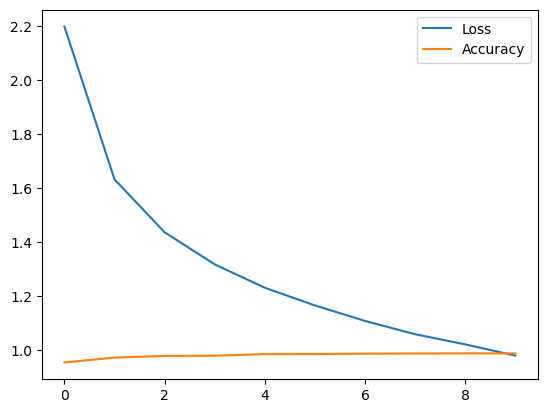

Accuracy: 98.850000%


In [17]:
import matplotlib.pyplot as plt

plt.plot(loss_history, label="Loss")
plt.plot(acc_history, label="Accuracy")
plt.legend()
plt.show()

print(f"Accuracy: {acc_history[-1]:%}")